本章我们将介绍以下内容：
- 使用非线性激活函数与线性模型的关键区别
- 不同种类的激活函数
- `pytorch`的`nn`模块，包括神经网络的搭建块
- 用神经网络解决一个简单地线性问题

前几章我们已经实现了用线性模型处理回归问题，我们这一章会重点放在对于模型结构的研究上。我们可以将前面用到的线性模型换成二次型函数，但是这样还是在刻意的猜测函数的结构。接下来我们介绍的神经网络，没有具体的公式表达，但是却功能强大，只要节点足够多，几乎可以拟合所有函数关系。让我们一起来探索。

# Artificial neurons

神经网络单元是神经网络的基本组成结构，它其实很简单，是实现的是给定一个输入，先进行一个线性变换，再将结果通过一个非线性激活函数，公式如下：
$$o = \tanh(w\cdot x+b)$$
其中，`o`是输出，`x`是输入，`w`和`b`是参数，`tanh`是一个非线性激活函数.

## All you need is activation

激活函数的作用是将输入的线性组合结果压缩到一个合理范围内，这样的话我们就可以定义结果的最值，方便比较计算。为了将结果有效的压缩到一定范围内，我们可以使用以下方法：
- 限制输出值，超过范围的就设定成特定值，这里我们可以使用`torch.nn.Hardtanh`。
- 激活函数是一条曲线，输出值可以映射到一个对应的值，比如说`torch.nn.Sigmoid`或者`torch.tanh`等等

激活函数的性质：
1. 非线性，可以让模型拟合更多复杂的函数
2. 可微的，这样的话可以计算梯度

没有激活函数的话，网络就会退化成复杂的多项式结构或者很难去训练。

`linear+activation`结构的好处有：
1. 不同的节点对于相同的输入，结果不同
2. 输入的误差会影响那些处在敏感区间的节点，很少影响其他节点
3. 激活函数在敏感区域的导数为1，所以在用梯度下降法进行参数估计时相当于进行的是线性拟合

# The PyTorch nn module

pytorch提供了torch.nn，包含了搭建神经网络所需的构建基块。

In [2]:
import torch.nn as nn
import numpy as np
import torch
import torch.optim as optim

In [3]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)   #返回一个打乱顺序的索引

train_indices = shuffled_indices[:-n_val]      #训练数据的索引
val_indices = shuffled_indices[-n_val:]     #验证数据的索引

t_u_train = t_u[train_indices]         #根据索引确定训练数据
t_c_train = t_c[train_indices]         

t_u_val = t_u[val_indices]             #根据索引确定验证数据
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train          #进行归一化
t_un_val = 0.1 * t_u_val


linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[-2.6100],
        [-3.3981]], grad_fn=<AddmmBackward>)

In [4]:
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[-0.6305]], requires_grad=True), Parameter containing:
 tensor([0.9144], requires_grad=True))

In [5]:
#可以输入一个值
x = torch.ones(1)
linear_model(x)

tensor([0.2839], grad_fn=<AddBackward0>)

In [6]:
#也可以输入一个batch
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.2839],
        [0.2839],
        [0.2839],
        [0.2839],
        [0.2839],
        [0.2839],
        [0.2839],
        [0.2839],
        [0.2839],
        [0.2839]], grad_fn=<AddmmBackward>)

In [8]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_un_train, t_un_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_un_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_un_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch, float(loss_train), float(loss_val)))

In [9]:
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [10]:
training_loop(n_epochs=3000, optimizer=optimizer, model=linear_model, loss_fn=nn.MSELoss(), t_un_train=t_un_train, t_c_train=t_c_train, t_un_val=t_un_val, t_c_val=t_c_val)

Epoch 1, Training loss 221.9033203125, Validation loss 435.57855224609375
Epoch 1000, Training loss 3.6031904220581055, Validation loss 5.560194969177246
Epoch 2000, Training loss 2.9542348384857178, Validation loss 4.108005523681641
Epoch 3000, Training loss 2.941573143005371, Validation loss 3.9285213947296143


In [11]:
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[5.2048]], requires_grad=True), Parameter containing:
 tensor([-16.8145], requires_grad=True))

接下来我们将线性模型替换成神经网络模型：

In [12]:
#模型由两层线性层组合而成，第一个线性层输入size为1， 输出size为13；
#第二个线性层输入size为13， 输出size为1。
seq_model = nn.Sequential(nn.Linear(1, 13), nn.Tanh(), nn.Linear(13, 1))

In [13]:
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [14]:
#可以看到输出size为13，那么对应的参数就有13对(weight,bias)
list(seq_model.parameters())

[Parameter containing:
 tensor([[-0.5665],
         [-0.4659],
         [ 0.8794],
         [-0.9888],
         [-0.3810],
         [ 0.6755],
         [ 0.1960],
         [-0.6058],
         [ 0.1024],
         [ 0.9887],
         [ 0.7299],
         [ 0.8483],
         [ 0.0720]], requires_grad=True), Parameter containing:
 tensor([-0.9587, -0.9334, -0.1920, -0.0596,  0.8987, -0.3884, -0.9683,  0.6494,
          0.4211, -0.8466, -0.6837,  0.8153,  0.0725], requires_grad=True), Parameter containing:
 tensor([[ 0.1586, -0.2062, -0.0662, -0.2136, -0.2773, -0.0822,  0.0230, -0.2292,
          -0.2514,  0.2159,  0.0305, -0.0365, -0.0374]], requires_grad=True), Parameter containing:
 tensor([-0.0050], requires_grad=True)]

可以通过模型的`named_parameters()`方法查看`parameters`:

In [15]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


模型建立的时候除了像上面提到的以外，还可以传入一个`OrderedDict`,如下所示：

In [16]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

In [17]:
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

用上面这种方法可以对每一层进行命名，方便查看：

In [19]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [20]:
#这样的话我们就可以查看某一层的参数
seq_model.output_linear.bias

Parameter containing:
tensor([-0.1038], requires_grad=True)

我们可以使用上面的模型进行训练：

In [21]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(n_epochs=5000, optimizer=optimizer, model=seq_model, loss_fn=nn.MSELoss(), t_un_train=t_un_train, t_un_val=t_un_val, t_c_train=t_c_train, t_c_val=t_c_val)

Epoch 1, Training loss 156.14906311035156, Validation loss 314.62567138671875
Epoch 1000, Training loss 5.7342000007629395, Validation loss 4.991886138916016
Epoch 2000, Training loss 2.5698368549346924, Validation loss 1.36119544506073
Epoch 3000, Training loss 1.7276395559310913, Validation loss 3.3479700088500977
Epoch 4000, Training loss 1.5687155723571777, Validation loss 3.6478347778320312
Epoch 5000, Training loss 1.5279878377914429, Validation loss 3.7995691299438477


我们也可以作图看看训练出来的模型对于数据的拟合程度：

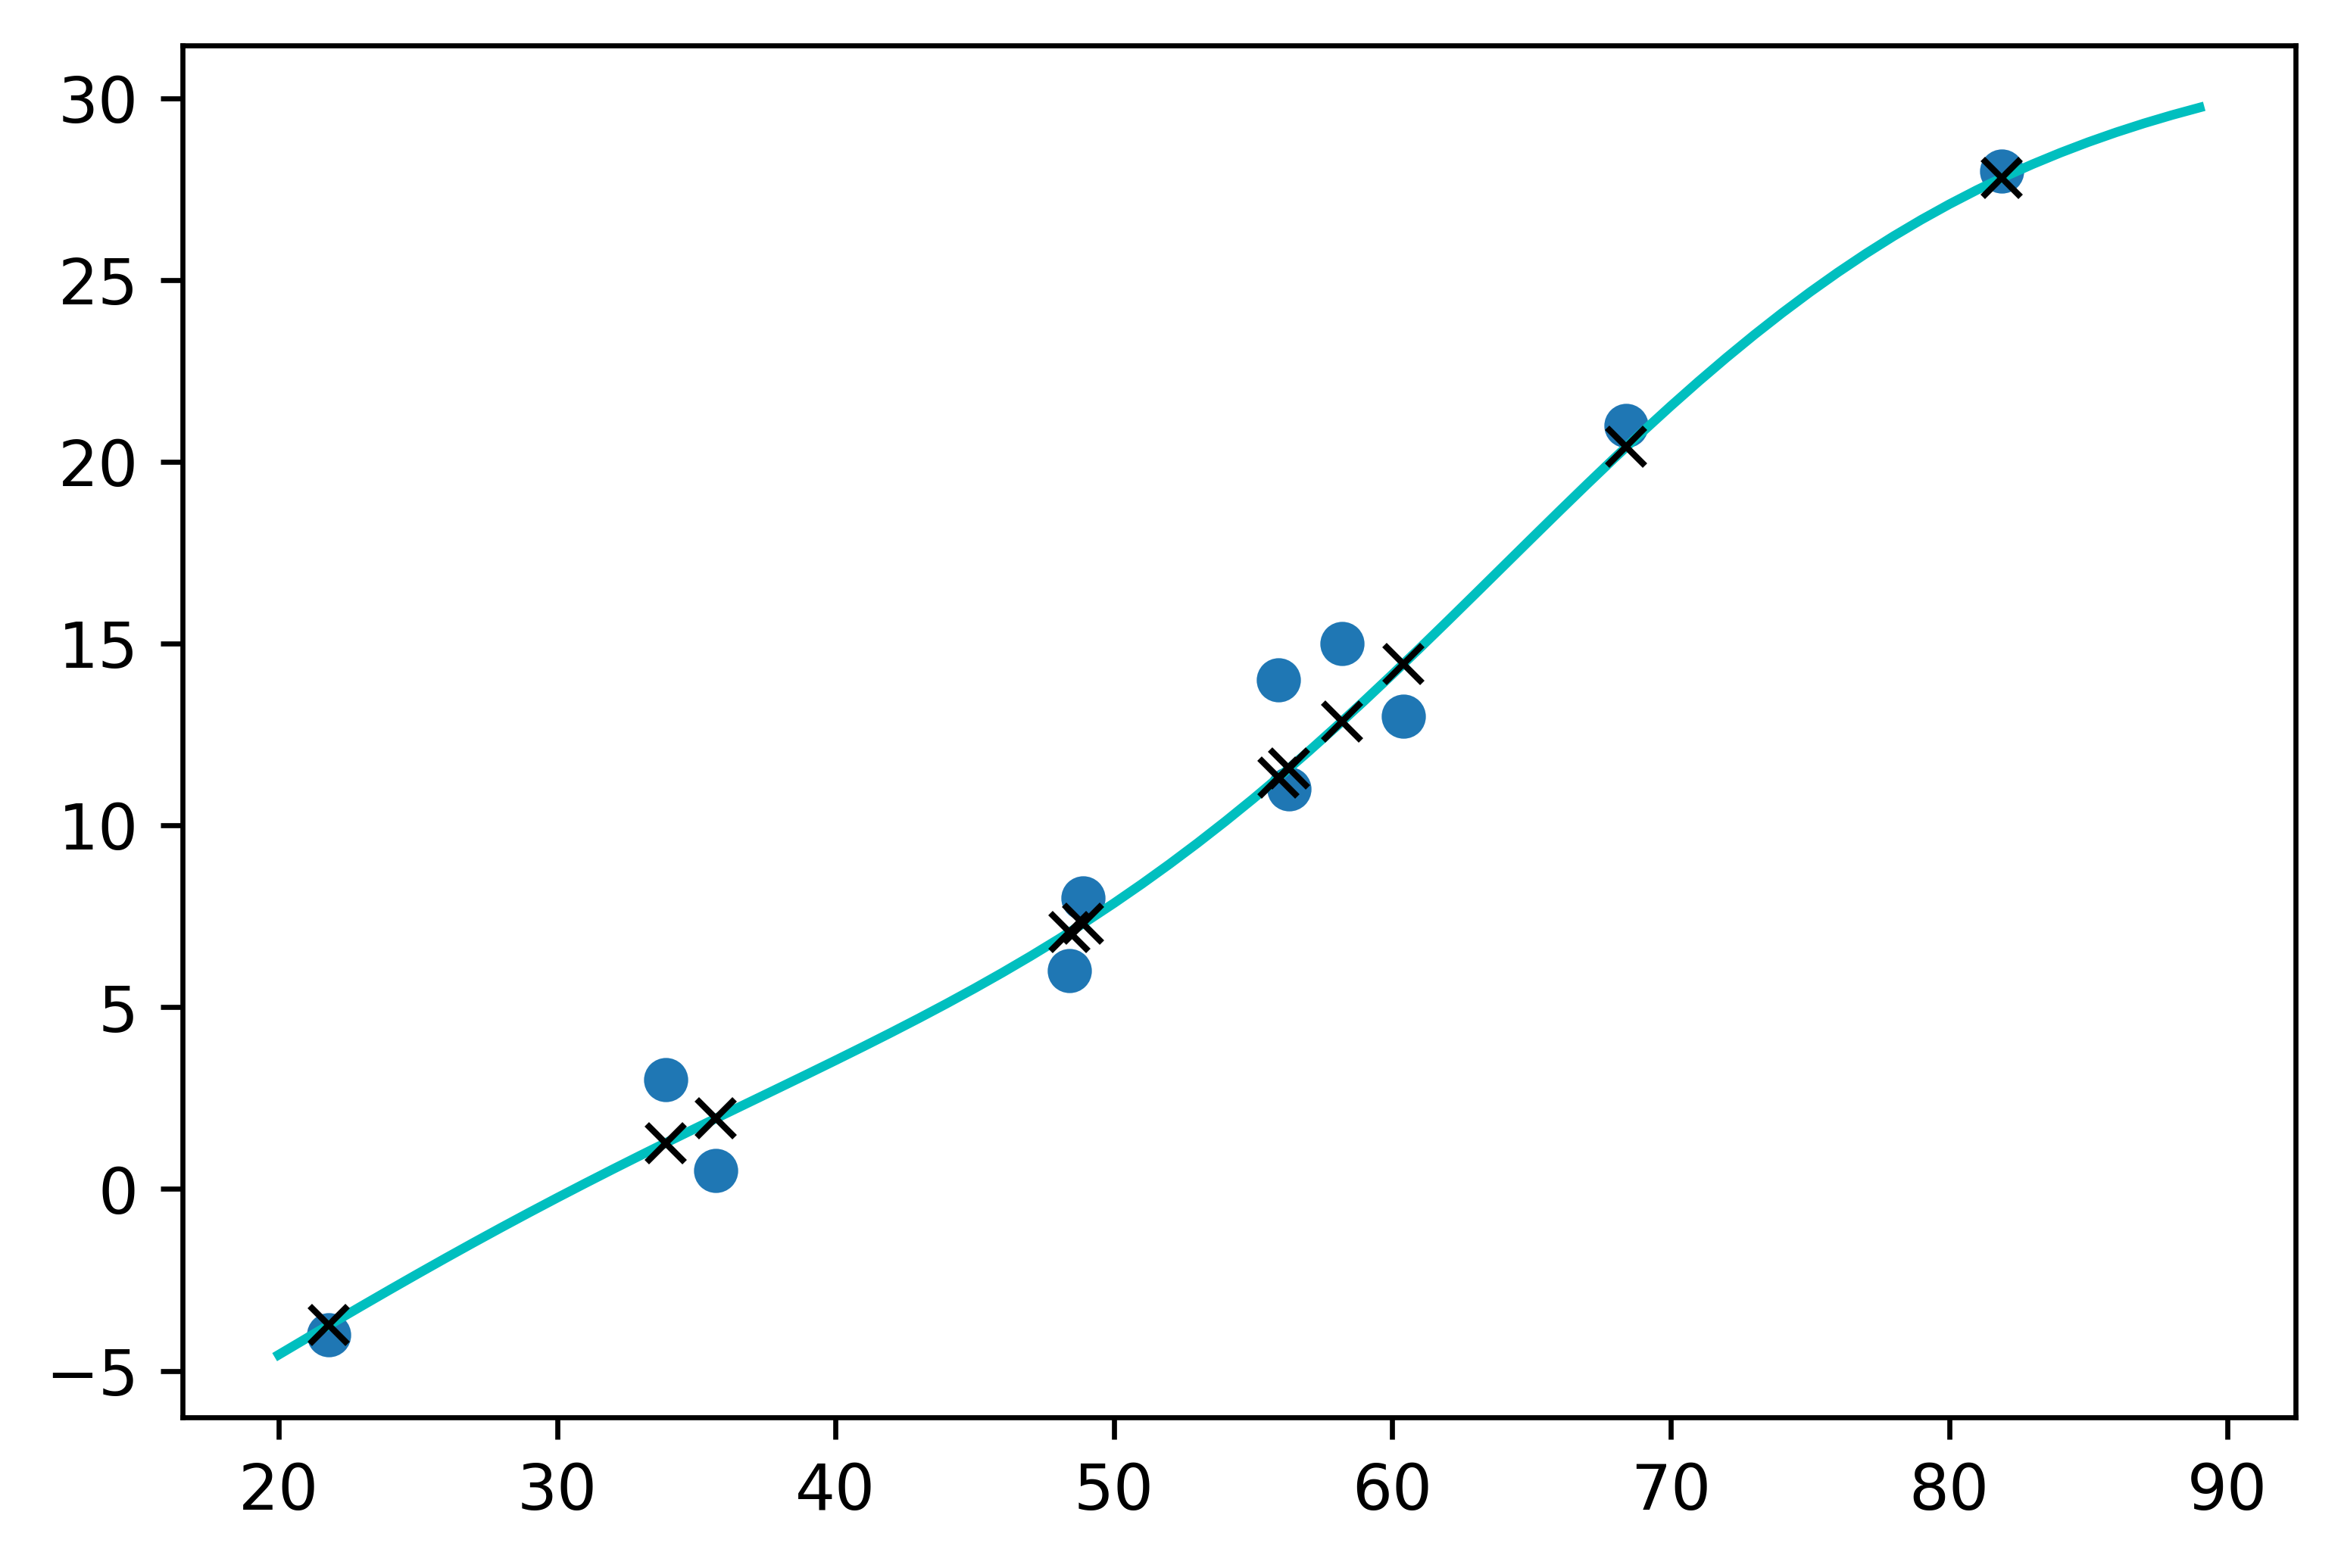

In [24]:
from matplotlib import pyplot as plt 

t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=600)
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1*t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1*t_u).detach().numpy(), 'kx')
#detach()作用是返回一个不带有grad的计算图

plt.show()

# Subclassing nn.Module

以上我们实现了生成模型的过程，但是对于更大更复杂的模型，我们需要继承`nn.module`，生成子类。我们要做的事是描述模型结构，书写`.forward()`函数

In [26]:
class SubclassModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_linear = nn.Linear(1, 13)
        self.hidden_activation = nn.Tanh()
        self.output_linear = nn.Linear(13, 1)
        
    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = self.hidden_activation(hidden_t)
        output_t = self.output_linear(activated_t)
        return output_t

In [27]:
subclass_model = SubclassModel()   #通过子类生成对象
subclass_model

SubclassModel(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

In [30]:
optimizer = optim.SGD(subclass_model.parameters(), lr=1e-3)

training_loop(n_epochs=5000, optimizer=optimizer, model=subclass_model, loss_fn=nn.MSELoss(), t_un_train=t_un_train, t_un_val=t_un_val, t_c_train=t_c_train, t_c_val=t_c_val)

Epoch 1, Training loss 152.07672119140625, Validation loss 306.2896728515625
Epoch 1000, Training loss 4.74757194519043, Validation loss 4.35479736328125
Epoch 2000, Training loss 2.2103986740112305, Validation loss 3.2447447776794434
Epoch 3000, Training loss 1.7396142482757568, Validation loss 3.4338135719299316
Epoch 4000, Training loss 1.6204159259796143, Validation loss 3.719176769256592
Epoch 5000, Training loss 1.5598973035812378, Validation loss 3.939427137374878


以上代码实现了一个模型，但是我们还是有更加通用的写法，那就是引入一些`function`,简化写法，比如我们将`__init__()`里面的`hidden_activation`删除，然后在`forward`里面对应地方使用函数调用。这样的话当模型体积较大时，会简化很多：

In [28]:
class SubclassFunctionalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_linear = nn.Linear(1, 14)
        self.output_linear = nn.Linear(14, 1)
        
    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = torch.tanh(hidden_t)
        output_t = self.output_linear(activated_t)
        return output_t

In [29]:
func_model = SubclassFunctionalModel()
func_model

SubclassFunctionalModel(
  (hidden_linear): Linear(in_features=1, out_features=14, bias=True)
  (output_linear): Linear(in_features=14, out_features=1, bias=True)
)

In [31]:
optimizer = optim.SGD(func_model.parameters(), lr=1e-3)

training_loop(n_epochs=5000, optimizer=optimizer, model=func_model, loss_fn=nn.MSELoss(), t_un_train=t_un_train, t_un_val=t_un_val, t_c_train=t_c_train, t_c_val=t_c_val)

Epoch 1, Training loss 155.59869384765625, Validation loss 313.2813720703125
Epoch 1000, Training loss 4.519488334655762, Validation loss 4.163918495178223
Epoch 2000, Training loss 2.1618945598602295, Validation loss 3.235184669494629
Epoch 3000, Training loss 1.7291923761367798, Validation loss 3.4555132389068604
Epoch 4000, Training loss 1.6227543354034424, Validation loss 3.7374613285064697
Epoch 5000, Training loss 1.5666199922561646, Validation loss 3.958378553390503
